In [117]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,Callback
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn 
from tensorflow.keras.applications import MobileNetV2
from matplotlib.backends.backend_pdf import PdfPages
from tensorflow.keras.layers import (
    Input, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
import warnings
import math
import random
warnings.filterwarnings("ignore", category=UserWarning)

In [108]:
# Count images in directory
def count_images_in_dir(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_in_dir('ewaste-dataset/train_resized')
val_counts = count_images_in_dir('ewaste-dataset/val_resized')
test_counts = count_images_in_dir('ewaste-dataset/test_resized')

counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).fillna(0).astype(int)

pdf = PdfPages("ewaste_report.pdf")

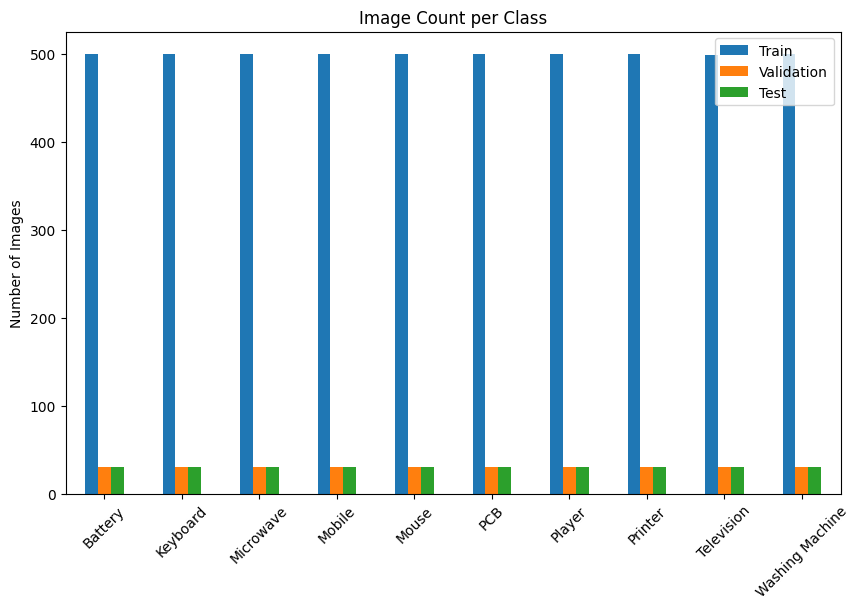

In [109]:
# Bar plot of image count
fig, ax = plt.subplots(figsize=(10,6))
counts_df.plot(kind='bar', ax=ax)
ax.set_title("Image Count per Class")
ax.set_ylabel("Number of Images")
ax.set_xticklabels(counts_df.index, rotation=45)
pdf.savefig(fig)
plt.show()
plt.close()

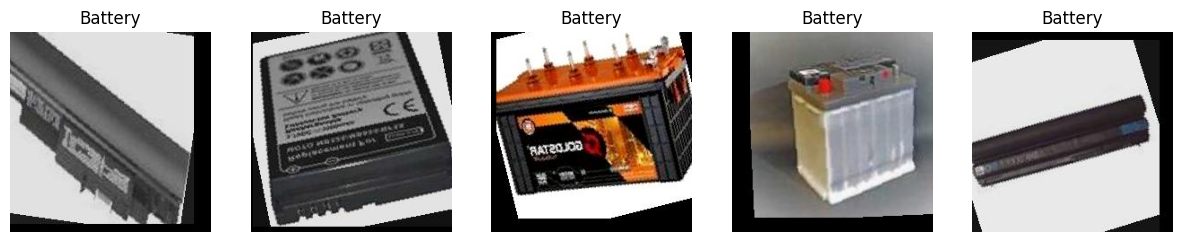

In [110]:
# Display sample images
def save_sample_images(base_dir, class_name, n=5):
    img_dir = os.path.join(base_dir, class_name)
    images = os.listdir(img_dir)[:n]
    fig = plt.figure(figsize=(15,3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    pdf.savefig(fig)
    plt.show()
    plt.close()

save_sample_images("ewaste-dataset1/train", list(train_counts.keys())[0])

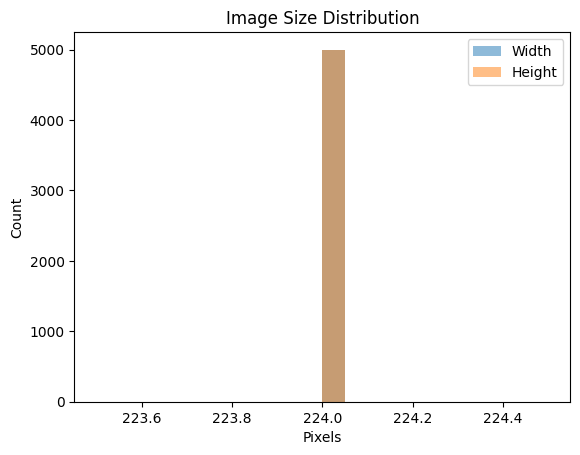

In [111]:
# Image size distribution
shapes = [(Image.open(os.path.join("ewaste-dataset/train_resized", cls, img)).size)
          for cls in os.listdir("ewaste-dataset/train_resized") for img in os.listdir(os.path.join("ewaste-dataset/train_resized", cls))]
widths, heights = zip(*shapes)

fig = plt.figure()
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
pdf.savefig(fig)
plt.show()
plt.close()

In [112]:
# 1. Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# 2. Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'ewaste-dataset/train_resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    'ewaste-dataset/val_resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    'ewaste-dataset/test_resized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Build Model with Frozen Base
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Phase 1: Train head only
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop1 = EarlyStopping(patience=3, restore_best_weights=True)
lr_scheduler1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop1, lr_scheduler1]
)

# 5. Phase 2: Fine-tune the top 50 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile with lower learning rate
model.compile(
    optimizer=RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# New callbacks for fine-tuning phase
early_stop2 = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # More epochs for better adaptation
    callbacks=[early_stop2, lr_scheduler2]
)



# 6. Evaluate and Save
loss, acc = model.evaluate(test_gen)
print(f"\n Final Test Accuracy: {acc*100:.2f}%")
model.save("ewaste_classifier_mobilenetv2.h5")

Found 4997 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4785 - loss: 1.5744 - val_accuracy: 0.8833 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7744 - loss: 0.6986 - val_accuracy: 0.9400 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8289 - loss: 0.5227 - val_accuracy: 0.9433 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8563 - loss: 0.4361 - val_accuracy: 0.9367 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8547 - loss: 0.4238 - val_accuracy: 0.9500 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8759 - loss: 0.3732 - val_accuracy: 0.9300 - val_loss: 0.2


 Final Test Accuracy: 92.67%


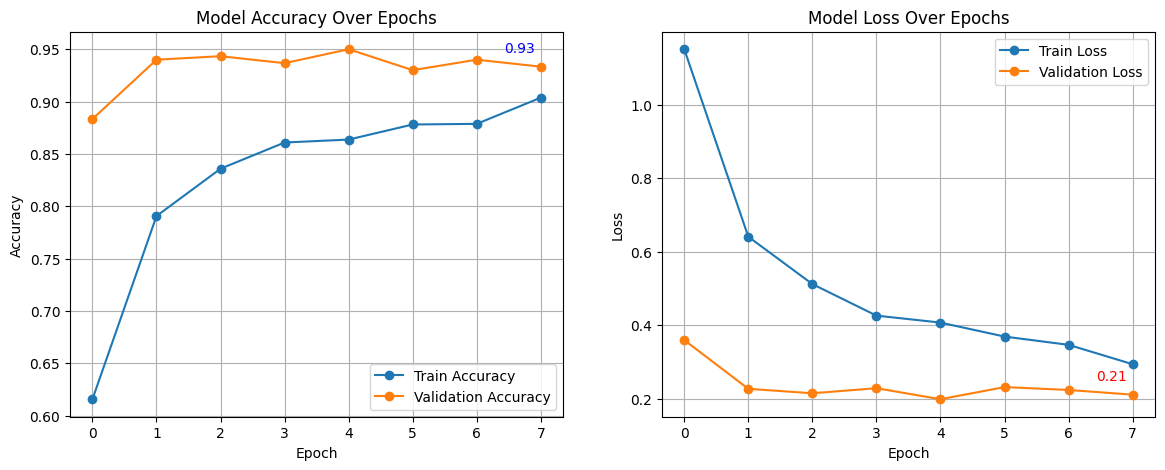

In [114]:
with PdfPages("training_report.pdf") as pdf:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axs[0].set_title('Model Accuracy Over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)
    axs[0].annotate(f"{history.history['val_accuracy'][-1]:.2f}",
                    xy=(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1]),
                    textcoords="offset points", xytext=(-15,10), ha='center', color='blue')
    
    # Plot Loss
    axs[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axs[1].set_title('Model Loss Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    axs[1].annotate(f"{history.history['val_loss'][-1]:.2f}",
                    xy=(len(history.history['val_loss'])-1, history.history['val_loss'][-1]),
                    textcoords="offset points", xytext=(-15,10), ha='center', color='red')

    # Save to PDF
    pdf.savefig(fig)
    plt.show()
    plt.close()

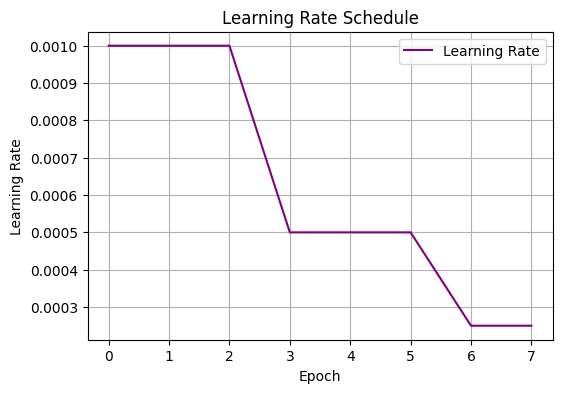

In [115]:
# Assuming learning rate history is tracked manually
lrs = [0.001 * (0.5 ** (epoch // 3)) for epoch in range(len(history.history['loss']))]

plt.figure(figsize=(6,4))
plt.plot(lrs, label='Learning Rate', color='purple')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
pdf.savefig()
plt.show()
plt.close()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step


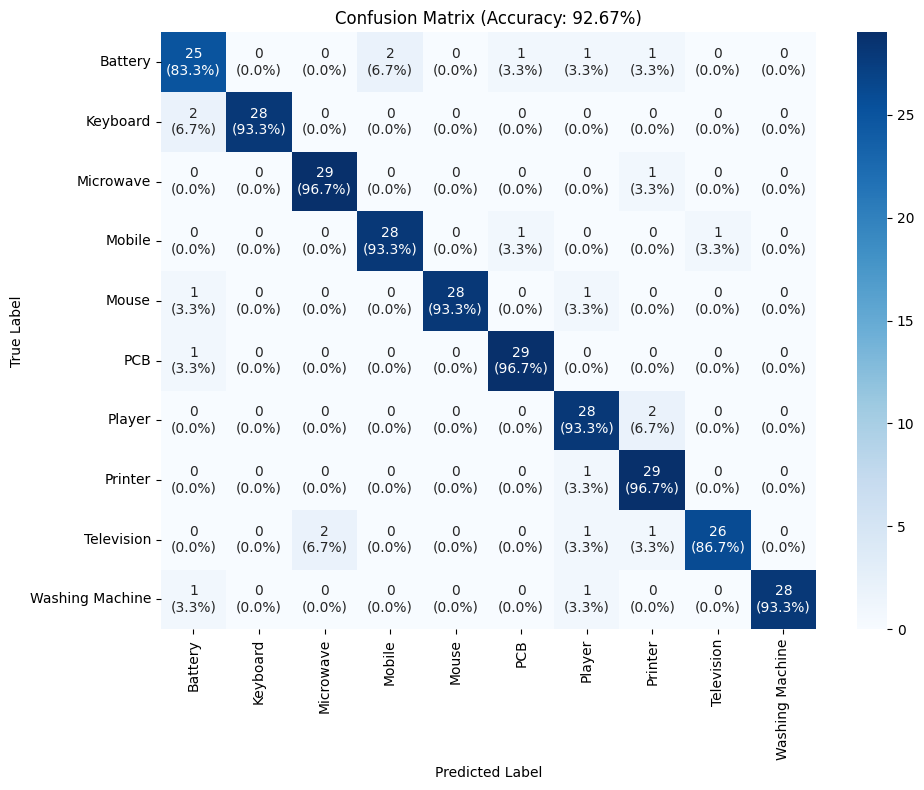

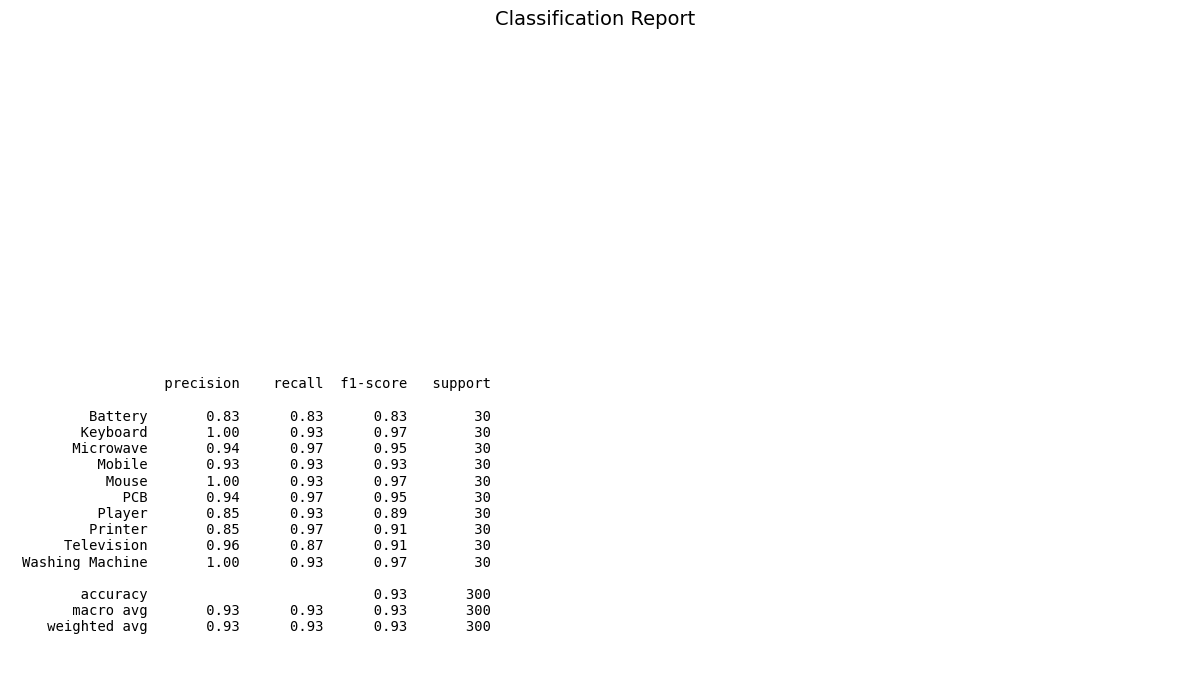

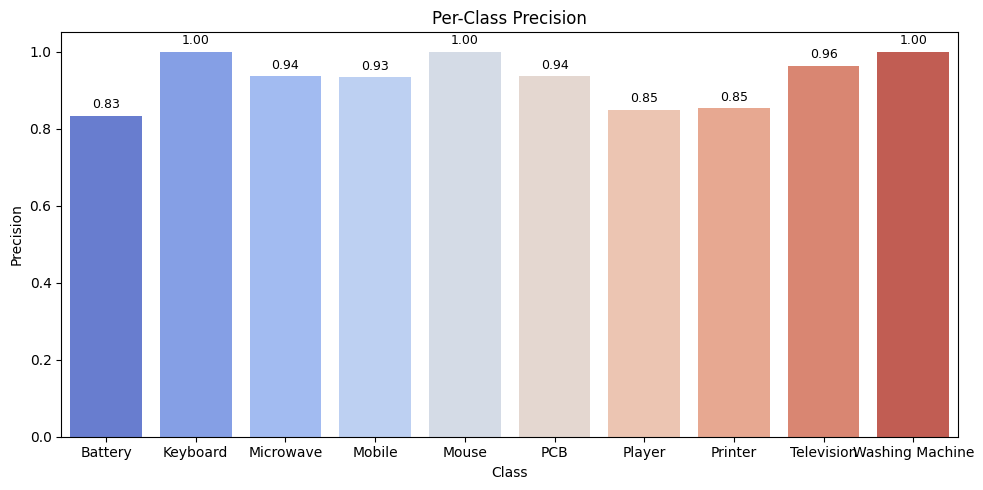

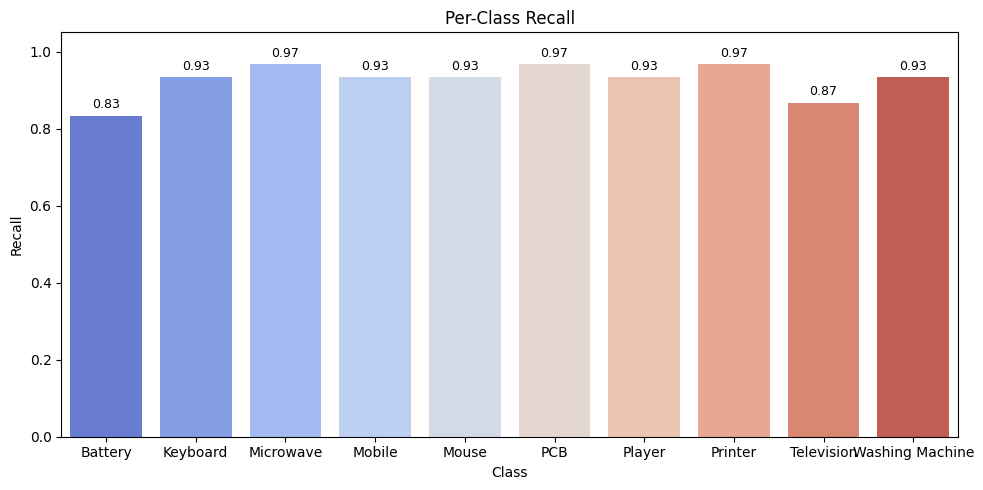

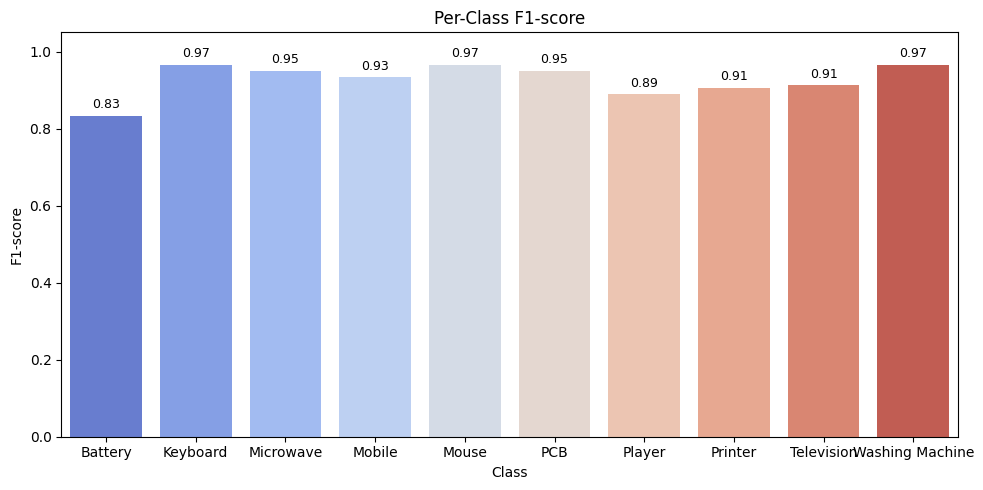

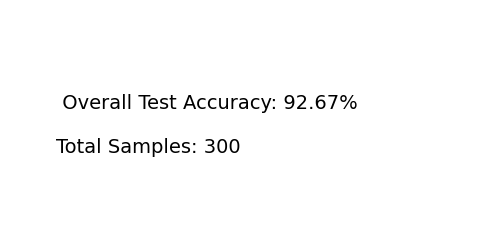

In [120]:
# Generate predictions
y_true = test_gen.classes
steps = math.ceil(test_gen.samples / test_gen.batch_size)
y_pred_probs = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
labels = list(test_gen.class_indices.keys())

# Metrics
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_text = classification_report(y_true, y_pred, target_names=labels)

with PdfPages("evaluation_report.pdf") as pdf:

    # 1. Confusion Matrix with % annotations
    fig_cm = plt.figure(figsize=(10, 8))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_labels = np.asarray([["{0}\n({1:.1%})".format(c, p) 
                             for c, p in zip(row_cm, row_percent)] 
                            for row_cm, row_percent in zip(cm, cm_normalized)])
    sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix (Accuracy: {acc*100:.2f}%)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig(fig_cm)
    plt.show()
    plt.close(fig_cm)

    # 2. Classification Report Text
    fig_cr = plt.figure(figsize=(12, 7))
    plt.axis('off')
    plt.title('Classification Report', fontsize=14)
    plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontfamily='monospace')
    plt.tight_layout()
    pdf.savefig(fig_cr)
    plt.show()
    plt.close(fig_cr)

    # 3. Bar Charts for Precision, Recall, F1-score
    for metric in ['precision', 'recall', 'f1-score']:
        fig = plt.figure(figsize=(10, 5))
        metric_values = [report_dict[label][metric] for label in labels]
        sns.barplot(x=labels, y=metric_values, hue=labels, dodge=False, palette='coolwarm', legend=False)
        plt.ylim(0, 1.05)
        plt.title(f'Per-Class {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Class')
        for i, val in enumerate(metric_values):
            plt.text(i, val + 0.02, f'{val:.2f}', ha='center', fontsize=9)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.show()
        plt.close(fig)

    # 4. Overall Accuracy Page
    fig_overall = plt.figure(figsize=(6, 3))
    plt.axis('off')
    summary_text = f" Overall Test Accuracy: {acc * 100:.2f}%\n\nTotal Samples: {len(y_true)}"
    plt.text(0.1, 0.5, summary_text, fontsize=14, va='center')
    pdf.savefig(fig_overall)
    plt.show()
    plt.close(fig_overall)

    # Create a markdown-like report in a .txt file
with open("summary_report.txt", "w") as f:
    f.write("#  Evaluation Summary\n\n")
    f.write(f"**Overall Accuracy:** {acc * 100:.2f}%\n")
    f.write(f"**Total Samples:** {len(y_true)}\n\n")
    f.write("## Classification Report\n\n")
    f.write(report_text)


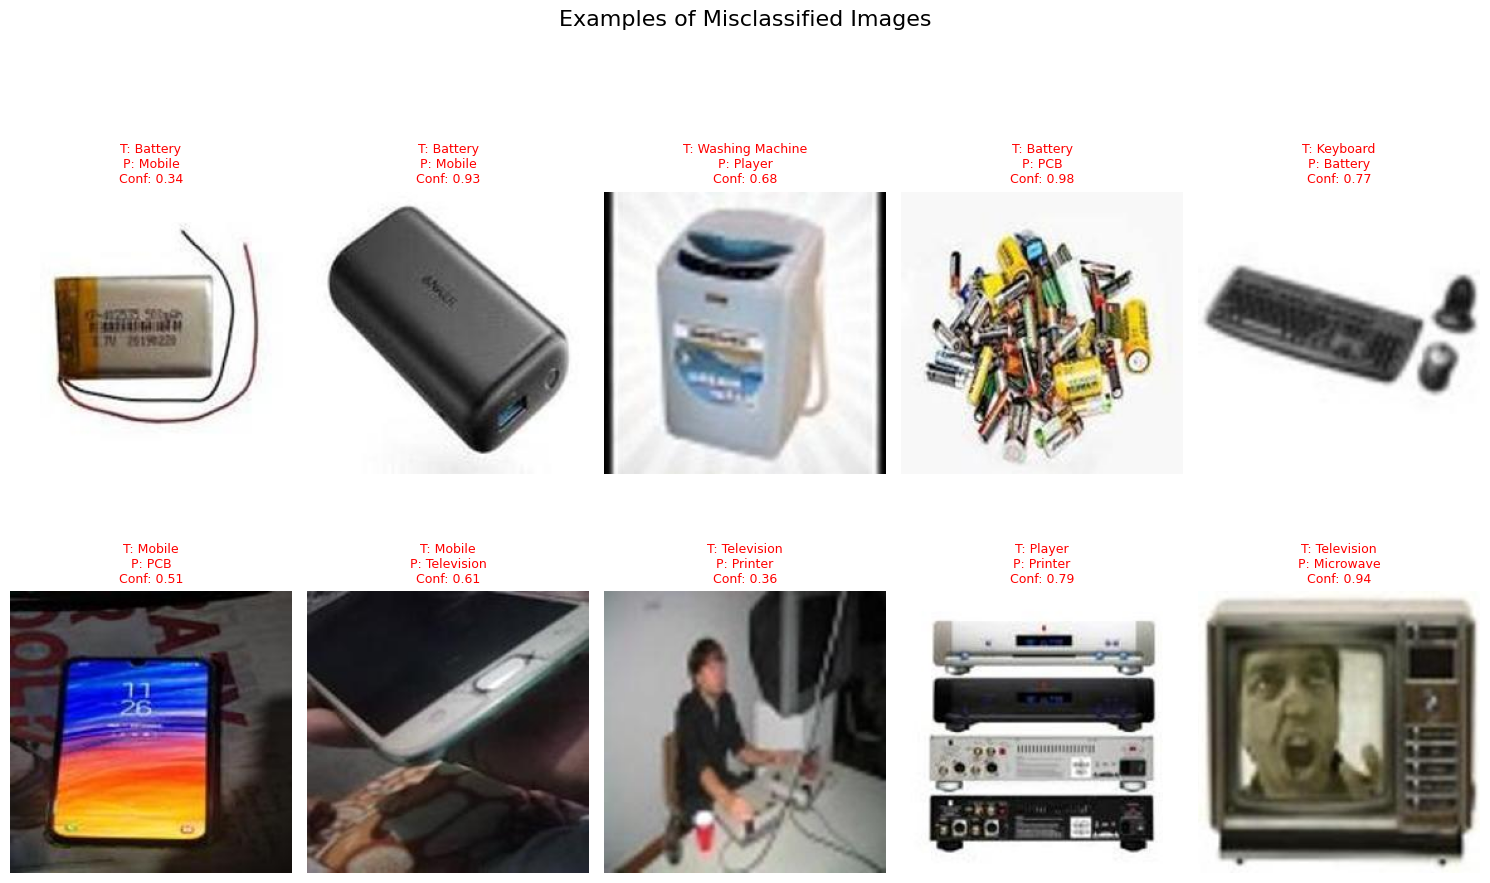

In [121]:
# Reverse mapping: index to class name
class_indices = {v: k for k, v in test_gen.class_indices.items()}

# Get file paths
filepaths = test_gen.filepaths

# Get probabilities and misclassified indices
misclassified_idxs = np.where(y_true != y_pred)[0]

# Limit to first 10 (or fewer if less than 10)
sampled_misclassified = random.sample(list(misclassified_idxs), min(10, len(misclassified_idxs)))

# Start new figure
fig_mis = plt.figure(figsize=(15, 10))
fig_mis.suptitle("Examples of Misclassified Images", fontsize=16)

for i, idx in enumerate(sampled_misclassified):
    img = plt.imread(filepaths[idx])
    pred_label = class_indices[y_pred[idx]]
    true_label = class_indices[y_true[idx]]
    confidence = np.max(y_pred_probs[idx])

    ax = fig_mis.add_subplot(2, 5, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"T: {true_label}\nP: {pred_label}\nConf: {confidence:.2f}", fontsize=9, color='red' if pred_label != true_label else 'green')

plt.tight_layout(rect=[0, 0, 1, 0.95])
pdf.savefig(fig_mis)
plt.show()
plt.close(fig_mis)
